В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score

warnings.filterwarnings('ignore')

In [2]:
raw_train_df = pd.read_csv('train.csv')
raw_train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [3]:
raw_train_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  str    
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  str    
 5   Gender           15000 non-null  str    
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), str(3)
memory usage: 1.9 MB


In [4]:
raw_train_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.569146e+07,658.944133,37.739600,5.025267,42729.791988,1.590933,0.788800,0.489667,117784.666193,0.203467
std,4330.271354,1.352050e+05,72.255926,8.218363,2.776678,59727.309419,0.532306,0.408174,0.499910,45734.445888,0.402590
min,0.000000,1.581102e+06,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,1.563514e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83058.140000,0.000000
50%,7499.500000,1.569018e+07,662.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123584.870000,0.000000
75%,11249.250000,1.575718e+07,708.000000,42.000000,7.000000,109531.017500,2.000000,1.000000,1.000000,156884.705000,0.000000
max,14999.000000,1.581569e+07,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [5]:
raw_train_df[raw_train_df.select_dtypes(include='object').columns].nunique()

Surname      764
Geography      3
Gender         2
dtype: int64

In [6]:
target_col = 'Exited'
train_df, val_df = train_test_split(
    raw_train_df,
    test_size=0.2,
    random_state=42,
    stratify=raw_train_df[target_col],
)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [7]:
drop_cols = ['id', 'CustomerId', 'Surname']
input_cols = [col for col in train_df.columns if col not in drop_cols + [target_col]]
input_cols

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [8]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

train_inputs.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7180,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31
80,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01
3365,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98
12236,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [9]:
numeric_cols = train_inputs.select_dtypes(include=['number']).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include=['object']).columns.tolist()

numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

In [10]:
# Такі колонки як HasCrCard та IsActiveMember по факту є категоріальними, а саме бінарними, тому віднесемо їх окремо 

binary_cols = ['HasCrCard','IsActiveMember']
numeric_cols = [col for col in numeric_cols if col not in binary_cols]

print('Числові колонки:', numeric_cols)
print('Бінарні колонки (де значення 0 або 1):', binary_cols)
print('Категоріальні колонки (для подальшої трансформації):', categorical_cols)

Числові колонки: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Бінарні колонки (де значення 0 або 1): ['HasCrCard', 'IsActiveMember']
Категоріальні колонки (для подальшої трансформації): ['Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [11]:
raw_train_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- ***На даному етапі заповнення пропущених значень не потребується, адже наші дані не мають null значень.***

Маштабуємо числові ознаки за допомогою StandardScaler, це допомагає логістичній регресії коректно навчатися, не надавати перевагу ознакам з великими значеннями та стабільно працювати з регуляризацією.

In [12]:
# Scale numeric features
scaler = StandardScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])


- ***До категоріальних ознак ми ще раніше НЕ включили колонку Surname, адже вона має забагато унікальних значень і логічніше цю ознаку не включати в модель.***  

З категоріальних значень до кодування у нас залишаються колонки Geography та Gender, які мають 3 та 2 унікальні значення відповідно. Отже їх ми можемо закодувати за допомогою OneHotEncoder.

In [13]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [14]:
train_inputs = train_inputs.drop(columns=categorical_cols)
val_inputs = val_inputs.drop(columns=categorical_cols)

In [15]:
display(train_inputs.head())
display(val_inputs.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.320187,-0.944682,-1.447264,1.475464,-1.108193,1.0,1.0,0.569450,1.0,0.0,0.0,0.0,1.0
10393,0.347838,0.161227,-1.087792,2.254434,-1.108193,1.0,0.0,0.603803,1.0,0.0,0.0,1.0,0.0
80,0.638166,-0.330288,0.350096,1.223831,0.769304,1.0,0.0,1.238026,0.0,1.0,0.0,0.0,1.0
3365,0.140460,2.495924,-1.806736,-0.717950,0.769304,0.0,1.0,-1.457116,0.0,0.0,1.0,0.0,1.0
12236,0.665816,-2.050591,-0.728320,-0.717950,0.769304,1.0,1.0,0.670629,1.0,0.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,0.762592,1.021379,-1.447264,1.214543,4.524299,1.0,1.0,-0.988144,0.0,1.0,0.0,0.0,1.0
3646,-0.910252,0.406985,-0.009376,-0.717950,0.769304,1.0,1.0,-1.750392,1.0,0.0,0.0,0.0,1.0
5306,0.997620,0.038348,-1.087792,-0.717950,0.769304,0.0,1.0,-0.022404,1.0,0.0,0.0,1.0,0.0
652,0.195761,0.652742,-0.368848,1.881867,-1.108193,0.0,1.0,-0.139723,1.0,0.0,0.0,1.0,0.0
2627,0.264887,-0.944682,-0.368848,-0.717950,0.769304,1.0,0.0,0.563519,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [16]:
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

train_inputs.to_parquet(os.path.join(output_dir, "train_inputs.parquet"), index=False)
train_targets.to_frame(target_col).to_parquet(os.path.join(output_dir, "train_targets.parquet"), index=False)

val_inputs.to_parquet(os.path.join(output_dir, "val_inputs.parquet"), index=False)
val_targets.to_frame(target_col).to_parquet(os.path.join(output_dir, "val_targets.parquet"), index=False)

In [17]:
print(os.listdir(output_dir))

['train_targets.parquet', 'train_inputs.parquet', 'val_inputs.parquet', 'val_targets.parquet']


In [18]:
!ls processed_data

train_inputs.parquet  val_inputs.parquet
train_targets.parquet val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [19]:
X_train = train_inputs
X_val = val_inputs

model = LogisticRegression(class_weight='balanced', penalty='l2',C=0.05, solver='liblinear', max_iter=5000)
model.fit(X_train, train_targets)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.05
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mult

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [20]:
def calculate_and_display_metrics(inputs, y_true, threshold, label=''):
    # Metrics
    proba   = model.predict_proba(inputs)[:, 1]
    pred = (proba >= threshold).astype(int)
    auroc = roc_auc_score(y_true, proba)
    f1 = f1_score(y_true, pred)
    cm = confusion_matrix(y_true, pred)
    print(f"{label} AUROC: {auroc:.7f}")
    print(f"{label} F1 Score: {f1:.7f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Display confusion matrix
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    labels = np.array([[f"{cm[i, j]}\n({cm_norm[i, j]:.1%})" for j in range(cm.shape[1])]
    for i in range(cm.shape[0])])
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", ax=axes[0])
    axes[0].set_xlabel('Prediction')
    axes[0].set_ylabel('Target')
    axes[0].set_title(f'{label} Confusion Matrix')

    # Display ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, proba)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.5f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'Receiver Operating Characteristic (ROC) Curve for {label}')
    axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

Training AUROC: 0.8839143
Training F1 Score: 0.6501743


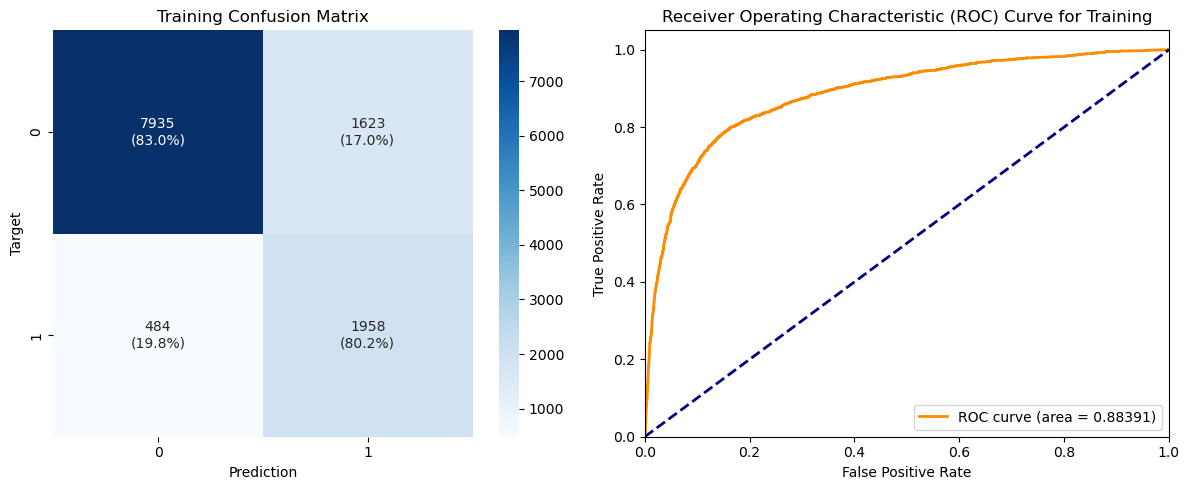

Validation AUROC: 0.8801125
Validation F1 Score: 0.6384615


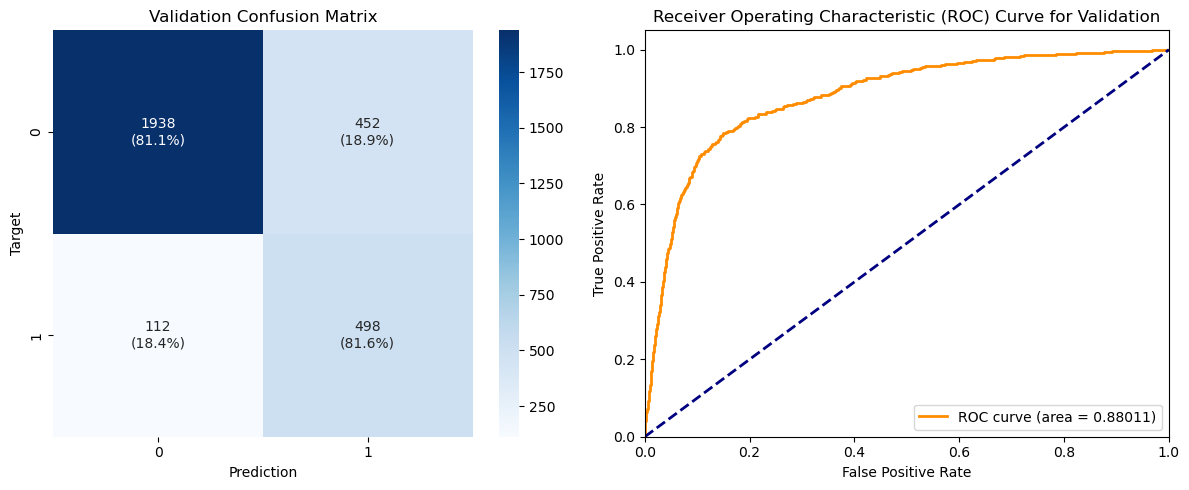

In [21]:
calculate_and_display_metrics (X_train, train_targets, 0.5, 'Training')
calculate_and_display_metrics (X_val, val_targets, 0.5, 'Validation')

Можемо зробити висновок, що модель логістичної регресії показує стабільну якість з AUROC ≈ 0.88 на тренувальних і валідаційних даних, що свідчить про добру здатність розрізняти класи без перенавчання. F1-score ≈ 0.64 при порозі 0.5 показує задовільний баланс між precision та recall, однак залишає простір для покращення.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [22]:
majority_class = int(train_targets.value_counts().idxmax())

baseline_train_preds = np.full_like(train_targets, majority_class)
baseline_val_preds = np.full_like(val_targets, majority_class)

train_proba   = model.predict_proba(X_train)[:, 1]
val_proba   = model.predict_proba(X_val)[:, 1]
baseline_train_acc = accuracy_score(train_targets, baseline_train_preds)
baseline_val_acc = accuracy_score(val_targets, baseline_val_preds)
model_train_acc = accuracy_score(train_targets, (train_proba >= 0.5).astype(int))
model_val_acc = accuracy_score(val_targets, (val_proba >= 0.5).astype(int))

print(f"Baseline accuracy (train): {baseline_train_acc:.4f}")
print(f"Baseline accuracy (val): {baseline_val_acc:.4f}")
print(f"Model accuracy (train): {model_train_acc:.4f}")
print(f"Model accuracy (val): {model_val_acc:.4f}")

Baseline accuracy (train): 0.7965
Baseline accuracy (val): 0.7967
Model accuracy (train): 0.8244
Model accuracy (val): 0.8120


Baseline має високу accuracy через дисбаланс класів, але не розв’язує задачу, тоді як логістична регресія дійсно може виявляти відтік клієнтів і є кращою моделлю. Тому краще використовувати не accuracy, а інші метрики для оцінки моделі.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [23]:
feature_cols = train_inputs.columns.tolist()
artifacts = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'numeric_cols': numeric_cols,
    'binary_cols' : binary_cols,
    'categorical_cols': categorical_cols,
    'feature_cols': feature_cols,
    'target_col': target_col,
    'encoded_cols': encoded_cols
}

joblib.dump(artifacts, "log_reg.joblib")

artifacts_loaded = joblib.load("log_reg.joblib")
model_2 = artifacts_loaded["model"]

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [24]:
def predict_raw_df(artifacts: dict, raw_df: pd.DataFrame):
    model = artifacts['model']
    scaler = artifacts['scaler']
    encoder = artifacts['encoder']
    numeric_cols = artifacts['numeric_cols']
    categorical_cols = artifacts['categorical_cols']
    feature_cols = artifacts['feature_cols']
    encoded_cols = artifacts['encoded_cols']

    df = raw_df.copy()
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    df[encoded_cols] = encoder.transform(df[categorical_cols])

    X_input = df[feature_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

predict_raw_df(artifacts_loaded, raw_train_df[:5])

array([0.02629536, 0.13585813, 0.75750709, 0.70238486, 0.99324639])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [25]:
test_raw_df = pd.read_csv('test.csv')
test_raw_df['Exited'] = predict_raw_df(artifacts_loaded, test_raw_df)

test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.225558
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.142655
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.413150
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.484403
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.221423


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [26]:
sample_submission = pd.read_csv("sample_submission.csv")
submission = sample_submission.copy()

pred_series = test_raw_df.set_index("id")["Exited"]
submission = submission.set_index("id")
submission["Exited"] = pred_series
submission = submission.reset_index()

display(submission.head())
submission.to_csv("submission_log_reg.csv", index=False)

,id,Exited
0,15000,0.225558
1,15001,0.142655
2,15002,0.413150
3,15003,0.484403
4,15004,0.221423
